In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification

import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2023-06-14 17:54:00.771487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2023-06-14 17:54:00.771543: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import pandas as pd

# Specify the path to your Excel file
excel_file_path = 'goEmotions.xlsx'

# Read the Excel file into a DataFrame
df = pd.read_excel(excel_file_path)

# Print the DataFrame
print(df)


                                                    text   labels
0      "Oh, how DARE you discuss the disgustingly unh...    anger
1      Press fucken charges the moment they use your ...    anger
2                                    Shut up 15 year-old    anger
3      I thought it was very good. The guy was one si...    anger
4      Lol. Build your own or make some tweaks to the...    anger
...                                                  ...      ...
55255  When I harass women with innuendo and they pol...  neutral
55256  That would involve reading, and redhats aren't...  neutral
55257  See her recent article in The Atlantic, in add...  neutral
55258  Before we continue, I would first like to ask ...  neutral
55259                                No but it should be  neutral

[55260 rows x 2 columns]


In [4]:
import pandas as pd

# Assuming your DataFrame is named 'df' and has a 'class' column

# Determine the minimum count of samples in a class
min_samples = df['labels'].value_counts().min()

# Group the DataFrame by the 'class' column
grouped = df.groupby('labels')

# Sample an equal number of samples from each class
balanced_df = grouped.apply(lambda x: x.sample(n=min_samples))

# Reset the index of the balanced DataFrame
balanced_df.reset_index(drop=True, inplace=True)
df = balanced_df
# Print the balanced DataFrame
print(balanced_df)

                                                    text    labels
0      Just like you can't underestimate the capacity...     anger
1      Everyone hates guys that talk shit and can't b...     anger
2                  Poo again? it really is an obsession.     anger
3      What country? That sounds like a sad septic sy...     anger
4      People have always liked kinky sex. But this i...     anger
...                                                  ...       ...
22374            Wow, not exactly a complimentary typo.   surprise
22375  You would be floored to hear how many times I ...  surprise
22376  Considering you are also a child, I can't say ...  surprise
22377                    Wow. That is shockingly uncool.  surprise
22378                              Surprise my what now?  surprise

[22379 rows x 2 columns]


### Preprocessing

In [7]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess(data):
    # Lowercase conversion
    data['text'] = data['text'].apply(
        lambda x: " ".join(x.lower() for x in x.split()))
    # Removal of special characters
    data['text']= data['text'].str.replace('[^\w\s]', ' ')
    # Removal of Digits & numbers
    data['text'] = data['text'].str.replace('\d+',' ')
    data['text'] = data['text'].str.replace('_',' ')
    # Removal of stopwords
    data['text'] = data['text'].apply( 
        lambda x: " ".join(x for x in x.split() if x not in stopwords.words('english')))
    # Lemmatization
    data['text'] = [WordNetLemmatizer().lemmatize(word) for word in data['text']]
    
    return data

df = preprocess(df)

In [10]:
# Preproceesed data
df.head()

,text,labels
0,like underestimate capacity evil underestimate...,anger
1,everyone hates guys talk shit back start shit ...,anger
2,poo really obsession,anger
3,country sounds like sad septic system sorry,anger
4,people always liked kinky sex bad kinky sex,anger


In [8]:
class_names = list(df['labels'].unique())

texts = list(df['text'])
labels = list(df['labels'])

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform the labels
encoded_labels = label_encoder.fit_transform(labels)

In [6]:
# Split the dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, encoded_labels, test_size=0.2, random_state=42)

In [7]:
# Custom Dataset class for loading your data
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [8]:
# Load pre-trained RoBERTa model and tokenizer
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)

In [9]:
# Define training parameters
batch_size = 64
max_length = 128
num_epochs = 20

# Create dataloaders for train and validation sets
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [10]:
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=7)  # 7 classes

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [11]:
# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [12]:
# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [16]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)

    model.eval()
    val_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(predictions == labels).item()

    val_loss /= len(val_dataloader)
    accuracy = correct_predictions / len(val_dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {accuracy:.4f}")


Epoch 1/20 - Train Loss: 1.3158 - Val Loss: 1.1116 - Val Accuracy: 0.6057
Epoch 2/20 - Train Loss: 1.0328 - Val Loss: 1.1170 - Val Accuracy: 0.6095
Epoch 3/20 - Train Loss: 0.9317 - Val Loss: 1.1255 - Val Accuracy: 0.6139
Epoch 4/20 - Train Loss: 0.8361 - Val Loss: 1.1754 - Val Accuracy: 0.6084
Epoch 5/20 - Train Loss: 0.7348 - Val Loss: 1.2476 - Val Accuracy: 0.5967
Epoch 6/20 - Train Loss: 0.6557 - Val Loss: 1.3170 - Val Accuracy: 0.5891
Epoch 7/20 - Train Loss: 0.5750 - Val Loss: 1.4421 - Val Accuracy: 0.5780
Epoch 8/20 - Train Loss: 0.5071 - Val Loss: 1.4896 - Val Accuracy: 0.5827
Epoch 9/20 - Train Loss: 0.4624 - Val Loss: 1.5577 - Val Accuracy: 0.5766
Epoch 10/20 - Train Loss: 0.4158 - Val Loss: 1.6073 - Val Accuracy: 0.5672
Epoch 11/20 - Train Loss: 0.3861 - Val Loss: 1.7003 - Val Accuracy: 0.5697
Epoch 12/20 - Train Loss: 0.3560 - Val Loss: 1.7643 - Val Accuracy: 0.5684
Epoch 13/20 - Train Loss: 0.3378 - Val Loss: 1.7716 - Val Accuracy: 0.5657
Epoch 14/20 - Train Loss: 0.3255 -

              precision    recall  f1-score   support

           0       0.47      0.48      0.48       614
           1       0.51      0.41      0.46       695
           2       0.63      0.65      0.64       682
           3       0.70      0.69      0.70       593
           4       0.49      0.46      0.47       626
           5       0.57      0.63      0.60       635
           6       0.61      0.65      0.63       631

    accuracy                           0.57      4476
   macro avg       0.57      0.57      0.57      4476
weighted avg       0.57      0.57      0.57      4476



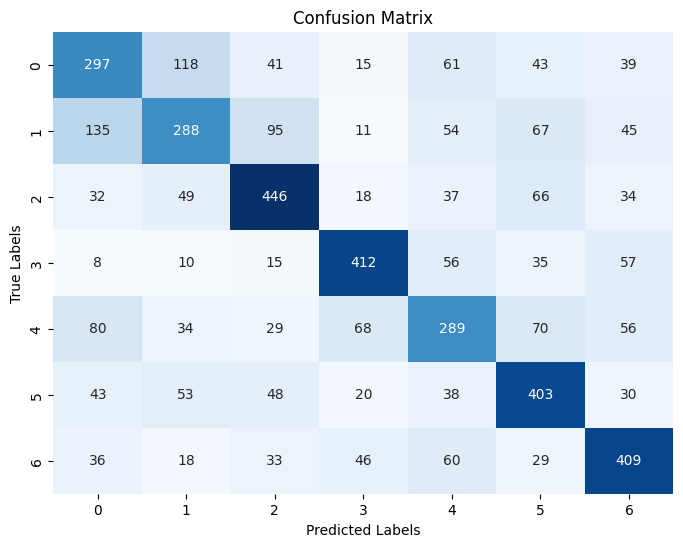

In [19]:
# Set the model in evaluation mode
model.eval()

true_labels = []
predicted_labels = []

# Iterate over the validation dataloader
for batch in val_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    # Perform forward pass
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Calculate predicted labels
    batch_predicted_labels = torch.argmax(outputs.logits, dim=1).tolist()

    true_labels.extend(labels.tolist())
    predicted_labels.extend(batch_predicted_labels)

# Convert labels to their original form
# true_labels = [label.item() for label in true_labels]

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print(report)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [13]:
class RobertaClassifier(nn.Module):
    def __init__(self, num_classes):
        super(RobertaClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(self.roberta.config.hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        output = self.fc1(output)
        output = nn.ReLU()(output)
        output = self.fc2(output)
        output = nn.ReLU()(output)
        logits = self.fc3(output)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return logits, loss
        else:
            return logits

In [14]:
# ...
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RobertaClassifier(num_classes=7)  # 7 classes
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_predictions = 0

    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        logits, loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        predictions = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predictions == labels).item()

    train_loss /= len(train_dataloader)
    train_accuracy = correct_predictions / len(train_dataset)

    model.eval()
    val_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(predictions == labels).item()

    val_loss /= len(val_dataloader)
    val_accuracy = correct_predictions / len(val_dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/20 - Train Loss: 1.5312 - Train Accuracy: 0.4780 - Val Loss: 1.1938 - Val Accuracy: 0.6019
Epoch 2/20 - Train Loss: 1.1043 - Train Accuracy: 0.6332 - Val Loss: 1.1120 - Val Accuracy: 0.6276
Epoch 3/20 - Train Loss: 0.9865 - Train Accuracy: 0.6778 - Val Loss: 1.1064 - Val Accuracy: 0.6168
Epoch 4/20 - Train Loss: 0.8796 - Train Accuracy: 0.7111 - Val Loss: 1.1455 - Val Accuracy: 0.6153
Epoch 5/20 - Train Loss: 0.7803 - Train Accuracy: 0.7470 - Val Loss: 1.2040 - Val Accuracy: 0.6088
Epoch 6/20 - Train Loss: 0.7018 - Train Accuracy: 0.7734 - Val Loss: 1.2229 - Val Accuracy: 0.6023
Epoch 7/20 - Train Loss: 0.6250 - Train Accuracy: 0.7973 - Val Loss: 1.2928 - Val Accuracy: 0.5967
Epoch 8/20 - Train Loss: 0.5571 - Train Accuracy: 0.8168 - Val Loss: 1.4066 - Val Accuracy: 0.5900
Epoch 9/20 - Train Loss: 0.5056 - Train Accuracy: 0.8322 - Val Loss: 1.4328 - Val Accuracy: 0.5802
Epoch 10/20 - Train Loss: 0.4674 - Train Accuracy: 0.8419 - Val Loss: 1.5016 - Val Accuracy: 0.5751
Epoch 11/

In [16]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Set the model in evaluation mode
model.eval()

true_labels = []
predicted_labels = []

# Iterate over the validation dataloader
for batch in val_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    # Perform forward pass
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Calculate predicted labels
    batch_predicted_labels = torch.argmax(outputs.logits, dim=1).tolist()

    true_labels.extend(labels.tolist())
    predicted_labels.extend(batch_predicted_labels)

# Convert labels to their original form
true_labels = [label.item() for label in true_labels]

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print(report)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

AttributeError: 'Tensor' object has no attribute 'logits'